In [34]:
import os 
from glob import glob
import pickle
from Semanticseg import read_image, semantic_seg
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns

In [31]:
#inputs:
pthDL = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\04_19_2024'

with open(os.path.join(pthDL, 'net.pkl'), 'rb') as f:
    data = pickle.load(f)
    model = data['model']
    classNames = data['classNames']
    # tile_size = data['sxy']


tile_size = 1024
# Paths to training and validation datasets:
pthDataset = r'C:\Users\Valentina\OneDrive - Johns Hopkins\Desktop\test png\test cm'

# Get paths to validation images and labels
test_images_path = sorted(glob(os.path.join(pthDataset, 'im', "*.png")))
test_masks_path = sorted(glob(os.path.join(pthDataset, 'ground truth', "*.png")))

In [32]:
y_true = []
y_pred = []

In [33]:
# Read images and masks, perform segmentation, and collect predictions and true labels
for img_path, mask_path in zip(test_images_path, test_masks_path):
    image_tensor = read_image(img_path, tile_size)
    mask_tensor = read_image(mask_path, tile_size, mask=True)

    if image_tensor is not None and mask_tensor is not None:
        pred_mask = semantic_seg(img_path, tile_size, model)
        true_mask = tf.squeeze(mask_tensor).numpy().astype(int)

        y_true.extend(true_mask.flatten())
        y_pred.extend(pred_mask.flatten())
    else:
        print(f"Error processing image or mask at {img_path} or {mask_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 45s 45s/step


In [40]:
valid_indices = [idx for idx in range(len(y_true)) if (y_pred[idx] != len(classNames)-1 and y_true[idx] != len(classNames)-1)]

y_true_new = [y_true[idx] for idx in valid_indices]
y_pred_new = [y_pred[idx] for idx in valid_indices]


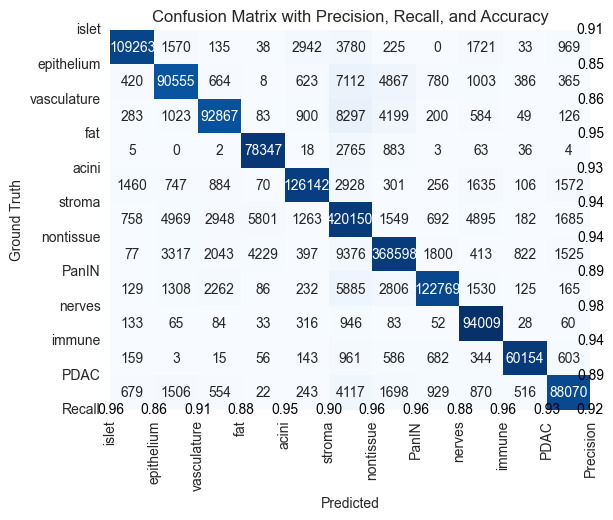

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import numpy as np
import matplotlib.colors as mcolors

# Create the confusion matrix
cm = confusion_matrix(y_true_new, y_pred_new, labels=range(len(classNames)-1))

# Normalize the confusion matrix for the heatmap colors
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate precision and recall for each class
precisions = [precision_score(y_true_new, y_pred_new, labels=[i], average='weighted', zero_division=0) for i in range(len(classNames)-1)]
recalls = [recall_score(y_true_new, y_pred_new, labels=[i], average='weighted', zero_division=0) for i in range(len(classNames)-1)]

# Calculate overall accuracy
accuracy = accuracy_score(y_true_new, y_pred_new)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap with normalized values for colors and raw counts as annotations
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', ax=ax, xticklabels=classNames[:-1], yticklabels=classNames[:-1], cbar=False)

# Add an extra tick location for the "Precision" row and "Recall" column
ax.set_xticks(np.arange(len(classNames)))
ax.set_yticks(np.arange(len(classNames)))

# Set tick labels
ax.set_xticklabels(classNames[:-1] + ['Precision'], rotation=90)
ax.set_yticklabels(classNames[:-1] + ['Recall'], rotation=0)

# Create a color map for precision and recall values
cmap = plt.get_cmap('RdYlGn', 100)
norm = mcolors.Normalize(vmin=0, vmax=1)

# Add precision values to the last row with colored squares
for i in range(len(classNames)-1):
    color = cmap(norm(precisions[i]))
    rect = plt.Rectangle((i-0.5, len(classNames)-0.5), 1, 1, facecolor=color, edgecolor='black')
    ax.add_patch(rect)
    ax.text(i, len(classNames)-1, f'{precisions[i]:.2f}', ha='center', va='center', color='black')

# Add recall values to the last column with colored squares
for i in range(len(classNames)-1):
    color = cmap(norm(recalls[i]))
    rect = plt.Rectangle((len(classNames)-0.5, i-0.5), 1, 1, facecolor=color, edgecolor='black')
    ax.add_patch(rect)
    ax.text(len(classNames)-1, i, f'{recalls[i]:.2f}', ha='center', va='center', color='black')

# Add overall accuracy to the bottom-right corner
ax.text(len(classNames)-1, len(classNames)-1, f'{accuracy:.2f}', ha='center', va='center', color='black')

# Set the title and axis labels
plt.title('Confusion Matrix with Precision, Recall, and Accuracy')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

# Adjust the spacing between ticks
plt.subplots_adjust(left=0.3, bottom=0.3)

plt.show()